# Introdução.
A rede de supermercados Boa Semente está implementando um novo sistema para auxiliar na venda de bebidas alcoólicas em suas lojas. O sistema auxiliará os atendentes na identificação de clientes menores de idade. O sistema precisa prever a idade dos clientes através das imagens das câmeras de segurança. O objetivo deste projeto é treinar um modelo capaz de realizar essa previsão.

# Bibliotecas

In [7]:
import pandas as pd
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

## Carregue os dados

O conjunto de dados é armazenado na pasta `/datasets/faces/`, onde você pode encontrar "
- A pasta `final_files` com 7,6k fotos "
- O arquivo `labels.csv` com rótulos, com duas colunas: `file_name` e `real_age` 

Dado que o número de arquivos de imagem é bastante alto, é aconselhável evitar a leitura de todos de uma vez, o que consumiria muito recursos computacionais. Recomendamos que você crie um gerador com o ImageDataGenerator. Este método foi explicado no Capítulo 3, Lição 7 deste curso.

O arquivo de rótulo pode ser carregado como um arquivo CSV normal.

In [8]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [9]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [10]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [11]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [12]:
def age_group(age):

    if age < 18:
        return 'Jovem'
    if 60 > age >= 18:
        return 'Adulto'
    if age >= 60:
        return 'Idoso'

Essa função verifica a idade e classifica como jovem, adulto ou idoso.

In [13]:
# aplicando a função e adicionando há uma nova coluna "class".
labels['class'] = labels['real_age'].apply(age_group)

In [14]:
datagen = ImageDataGenerator(rescale=1/255)

train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


**Conclusão**

Foram fornecidas 7.591 imagens para o treinamento e teste do modelo. Junto com as imagens, também foi fornecida uma tabela contendo os nomes dos arquivos de imagens e a idade das pessoas nas imagens. Não foram identificados valores ausentes, os tipos estão corretos e a distribuição não parece ser anormal. A idade mínima registrada é de 1 ano e a máxima é de 100 anos. Foi criada uma nova coluna para classificar as imagens com base na idade.

## Análise exploratória.

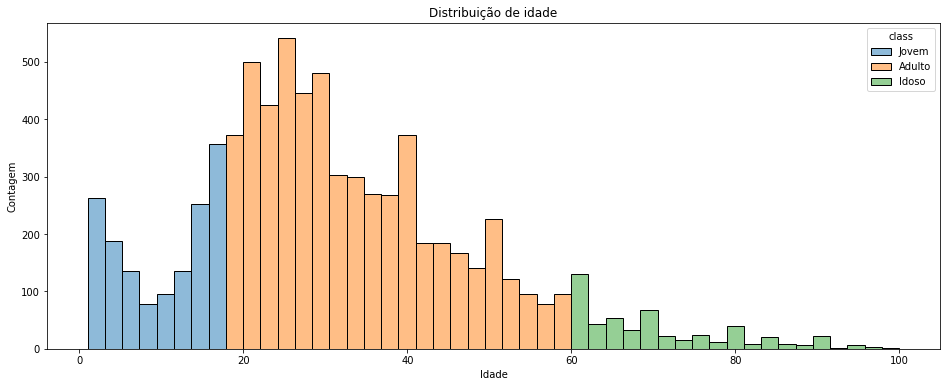

In [15]:
# As bliblioteca para plotagem foram colocadas aqui por estarem dando erro no espaço de cima.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
sns.histplot(labels,x='real_age',hue='class')
plt.title('Distribuição de idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()

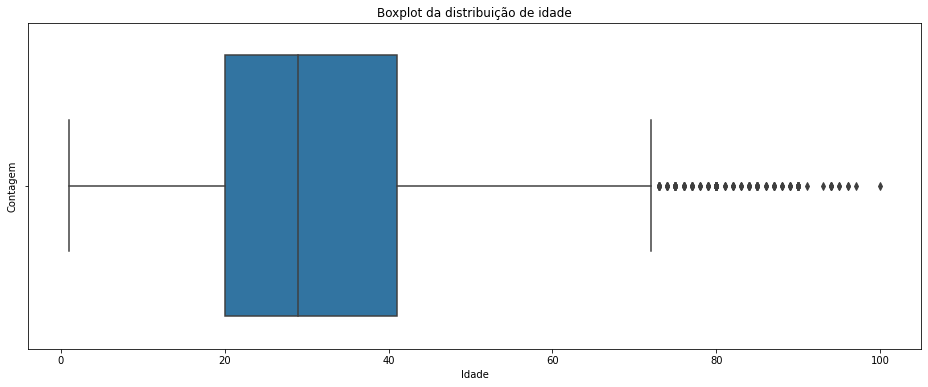

In [16]:
plt.figure(figsize=(16,6))
sns.boxplot(labels['real_age'])
plt.title('Boxplot da distribuição de idade')
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.show()

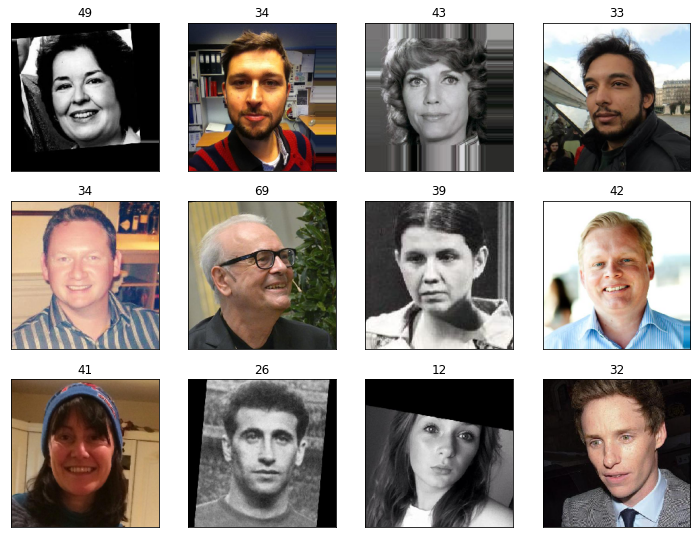

In [19]:
features, target = next(train_gen_flow)

# mostra 16 imagens

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title((f'{target[i]} anos'))
# remova os eixos e coloque as imagens mais próximas umas das outras para uma saída mais compacta
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Conclusões.

- Há um maior número de pessoas na faixa etária entre 20 e 40 anos.

- Até os 70 anos, observamos o shape possui formato de sino.

- Temos vários tipos de imagens, incluindo imagens em preto e branco, imagens fora de enquadramento, imagens esticadas e imagens de boa e má qualidade.

- Idealmente, a amostra teria mais exemplos na faixa etária de 16 a 25 anos, uma vez que o objetivo da tarefa está relacionado principalmente a essa faixa etária. No entanto, acredito que a falta de exemplos nessa faixa etária não prejudicará o treinamento do modelo.

## Modelagem.

O modelo será treinado em uma GPU na nuvem e, para realizar o treinamento, os códigos serão transferidos para a nuvem em funções.<br>

- A função <code>load_train</code> será responsável por carregar os dados necessários e retornar o conjunto de treinamento <code>train_gen_flow</code>.<br>
- A função <code>load_test</code> será responsável por carregar os dados necessários e retornar o conjunto de teste <code>test_gen_flow</code>.<br>
- A função <code>create_model</code> conterá o modelo configurado para o treinamento.<br>
- A função <code>train_model</code> será responsável por realizar o treinamento do modelo e retornará os resultados de treinamento, incluindo previsões com o MAE (Erro Absoluto Médio) como métrica.<br>

In [16]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [17]:
def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)
        
    
    return train_gen_flow

In [2]:
def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow

In [19]:
def create_model(input_shape=(224, 224, 3)):
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00025) # Pode ajustar a taxa de aprendizado
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    return model

In [20]:
def train_model(model, train_data, test_data, batch_size=None, epochs=29,steps_per_epoch=None, validation_steps=None):
    
    if step_per_epoch is None:
        step_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
             epochs = epochs,
             validation_data=test_data,
             batch_size=batch_size,
             steps_per_epoch=steps_per_epoch,
             validation_steps = validation_steps,
             verbose=1)
    
    return model

## Preparar o Script para a Execução na plataforma GPU

Script enviado para a plataforma.

In [21]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import pandas as pd


# In[ ]:


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='training',
        seed = 12345)
        
    
    return train_gen_flow


# In[ ]:


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split = .25,
        rescale = 1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224,244),
        batch_size = 16,
        class_mode = 'raw',
        subset='validation',
        seed = 12345)
    
    return test_gen_flow


# In[ ]:


def create_model(input_shape=(224, 224, 3)):
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.00025) # Pode ajustar a taxa de aprendizado
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    
    return model


# In[ ]:


def train_model(model, train_data, test_data, batch_size=None, epochs=25, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model


# In[ ]:


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')



### Resultado

**Resumo do output do modelo.**

<p>Train for 356 steps, validate for 119 steps
<p>Epoch 1/25
<p>356/356 - 38s - loss: 6.2243 - mae: 6.2243 - val_loss: 17.2433 - val_mae: 17.2441
<p>Epoch 5/25
<p>356/356 - 38s - loss: 4.0476 - mae: 4.0479 - val_loss: 7.1899 - val_mae: 7.2020
<p>Epoch 10/25
<p>356/356 - 39s - loss: 2.9949 - mae: 2.9951 - val_loss: 6.7020 - val_mae: 6.7082
<p>Epoch 15/25
<p>356/356 - 38s - loss: 2.5972 - mae: 2.5974 - val_loss: 6.7703 - val_mae: 6.7703
<p>Epoch 20/25
<p>356/356 - 38s - loss: 2.2832 - mae: 2.2834 - val_loss: 6.5401 - val_mae: 6.5450
<p>Epoch 25/25
<p>356/356 - 38s - loss: 2.2708 - mae: 2.2703 - val_loss: 6.6001 - val_mae: 6.6036</p>

<p>119/119 - 9s - loss: 6.6001 - mae: 6.6036</p><br>

**Test MAE: 6.6036**

## Conclusão

Como mensionado antes o objetivo desse projeto é prever a idade dos clientes que estão comprando bebidas alcoólicas para os atendes não as venderem para menores de idade.
Para realizar essa previsão foi utilizado um modelo de redes neurais convolucionais, pré-treinada com o uma batéria de imagens fornecidas pela ResNet50.As imagens do conjuto foram utilizadas nas medidas 224,224 , o treinamento ocorreu em 25 épocas, com a função de perda e métrica de avaliação MAE.
Com essas configurações foi possivel atingir um MAE de 6,6 no conjunto de teste, um otimo resultado, esse modelo está pronto para ser utilizado e ajudar os atendetes no seu dia a dia.

Os aumentos foram realizados usando estas operações:

Reflexões verticais e horizontais
Rotações de até 90 graus
Deslocamento vertical e horizontal das imagens em até 20% do tamanho original.
Usando um gerador para os conjuntos de treinamento e teste, os dados foram carregados do diretório. Modelei usando a arquitetura ResNet50 do TensorFlow e treinei o modelo e executei o script na plataforma GPU. O resultado da saída da plataforma GPU é mostrado acima. O modelo não está sobreajustado, uma vez que a perda e o erro médio absoluto estão reduzindo nos conjuntos de treinamento e teste. O MAE registrado no conjunto de teste foi 7,7068.

Utilizando conjuntos de dados com fotos de pessoas, uma rede neural convolucional foi construída e treinada na plataforma GPU com pontuação MAE inferior a 8,0. Os métodos de visão computacional desenvolvidos podem ser usados ​​para determinar a idade de uma pessoa a partir de uma foto. Este modelo será útil para a rede de supermercados Good Seed, ajudando a verificar a idade das pessoas para cumprir as leis sobre bebidas alcoólicas e não vender bebidas alcoólicas a menores de idade.